# Traffic tracker counting

This notebook will convert the traffic tracker object paths output into useful count data to conduct performance evaluation and dive deeper into pitfalls and problems and how to deal with them in post-processing.

### Import dependencies

In [59]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import geopandas as gpd
from shapely.geometry import Point, LineString

### Read in data

In [29]:
# load object paths
df = pd.read_csv('beachhill_pednet_1.csv', header=0)
                 #, names=['frame', 'class', 'time',  'id', 'age', 'time_last_update', 'bb_left', 'bb_top', 'bb_right', 'bb_bottom'])
df.shape

(2957, 11)

In [30]:
df.sample(5)

,frame_num,rpi_time,obj_class,obj_id,obj_age,obj_t_since_last_update,obj_hits,xmin,ymin,xmax,ymax
406,48,1621977010,vehicle,2,49,0,47,557,47,627,85
2032,175,1621977067,vehicle,25,105,0,92,685,60,749,110
2249,194,1621977077,vehicle,2,195,0,193,555,45,622,88
1274,110,1621977036,vehicle,2,111,0,109,562,46,626,85
1659,139,1621977050,vehicle,8,129,4,98,573,50,635,92


In [37]:
#  compute detection centroids
df['cx'] = 0.5 * (df['xmin'] + df['xmax'])
df['cy'] = 0.5 * (df['ymin']  + df['ymax'])

In [33]:
#Curious about units of time
print(df['rpi_time'].max() - df['rpi_time'].min())
print(df['frame_num'].max() - df['frame_num'].min())

144
299


In [9]:
# load helper image
IMG_PATH = 'frame_000000.jpg'
pil_img = Image.open(IMG_PATH)

### Analysis

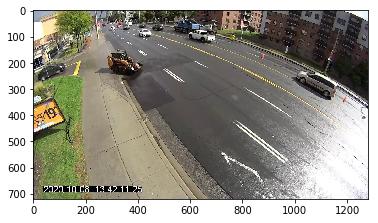

In [10]:
plt.imshow(pil_img)

In [14]:
# first, lets create a path which if crossed, will increment our counters
gates = [
    [(200,600), (850,250)],    # (xy1, xy2)
    [(875,250), (925,150)],   # (xy1, xy2)
]

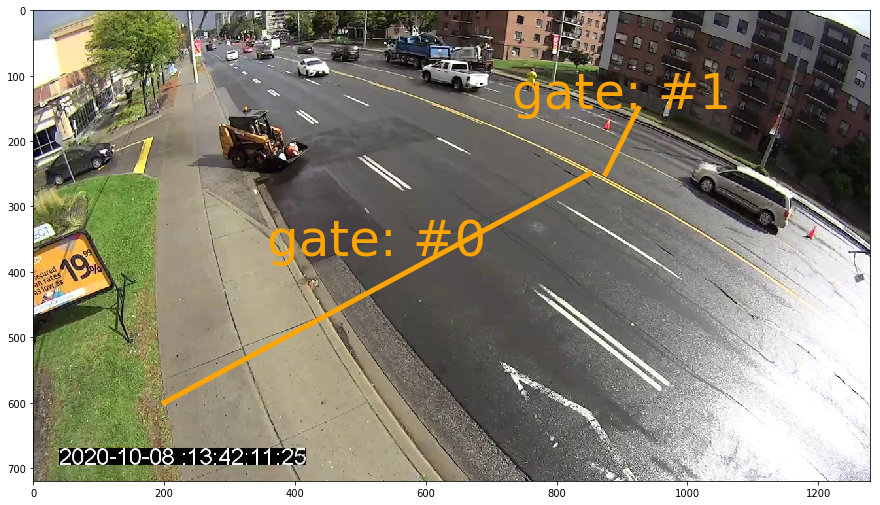

In [15]:
# let's validate that these gates are in the right place with a plot
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(pil_img)

for g, gate in enumerate(gates):
    x1, y1 = gate[0]
    x2, y2 = gate[1]
    x, y = [x1, x2], [y1, y2]
    plt.plot(x, y, color='orange', linewidth=5)

    plt.text(
        sum(x)/2,
        sum(y)/2 - 50, 
        "gate: #{}".format(g), 
        color='orange', 
        horizontalalignment='center',
        fontsize=50)
        
ax.set_aspect('equal')
plt.show()

Drawing trajectories of objects on the reference image. We see the centroids, and therefore the bounding boxes, extend beyond the bottom right of the image.

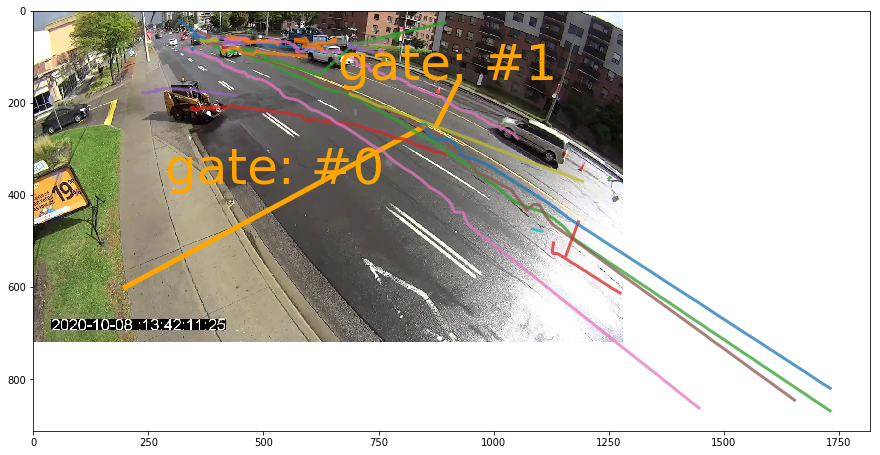

In [51]:
# Test plotting all trajectories
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(pil_img)

for g, gate in enumerate(gates):
    x1, y1 = gate[0]
    x2, y2 = gate[1]
    x, y = [x1, x2], [y1, y2]
    plt.plot(x, y, color='orange', linewidth=5)

    plt.text(
        sum(x)/2,
        sum(y)/2 - 50, 
        "gate: #{}".format(g), 
        color='orange', 
        horizontalalignment='center',
        fontsize=50)
        
#ax.set_aspect('equal')
for _, obj_path in df.groupby(by='obj_id'):
    ax.plot(obj_path['cx'], obj_path['cy'], lw=3, alpha=0.75)
plt.show()

The easiest way to get traffic counts from this point is to simply look at the time-dependent trajectory of each object and see if it crosses any of the gates. This means we need to create a simple function, which when given two line segments will return `True` if they cross and `False` if they don't or are only touching. [Source](https://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/) for this code.

In [16]:
def ccw(a, b, c):
    return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

In [19]:
def cross(gate, trajectory):
    g_0, g_1 = gate
    t_0, t_1 = trajectory
    return ccw(g_0, t_0, t_1) != ccw(g_1, t_0, t_1) and ccw(g_0, g_1, t_0) != ccw(g_0, g_1, t_1)

In [25]:
%%time
# now lets cycle throught each objects trajectory and determine if it has crossed either of the gates
obj_path.sort_values(by=['id','time'], ascending=True, inplace=True)
obj_path['trajectory'] =  tuple(obj_path[])
gate_counts_dict = defaultdict(int)
for n, obj_path in df.groupby(by='id'):
    
    # cycle through each time step of trajectory in ascending order
    for i, row in obj_path.sort_values(by='time', ascending=True).iterrows():
    
        # get position at current time
        xy_t0 = tuple(row[['cx', 'cy']].values)
        
        # get position at most recent historic time step
        xy_t1 = obj_path[ obj_path['frame'] < row['frame']].sort_values(by='frame', ascending=False)
        
        # if a previous time step is found, let's check if it crosses any of the gates
        if xy_t1.shape[0]>0:
            xy_t1 = tuple(xy_t1[['cx', 'cy']].values[0])
            
            # cycle through gates
            for g, gate in enumerate(gates):
                gate_counts_dict[g] += cross(gates[g], [xy_t0, xy_t1])        

CPU times: user 10.6 s, sys: 66.3 ms, total: 10.6 s
Wall time: 10.7 s


In [23]:
# print some results
for k, v in gate_counts_dict.items():
    print('GATE {k}: {v}'.format(k=k, v=v))

GATE 0: 152
GATE 1: 112


### Geopandas counting method

Trajectories and gates can be determined as polylines, and lines, respectively. Therefore there should be a simple intersect/cross way to determine if a vehicle crosses a gate.

In [56]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.cx, df.cy))

In [133]:
# Filter to objects that appear more than once so a trajectory can be created
# It's possible to apply multiple aggregations to a same columns using different functions
potential_lines = gdf.groupby('obj_id').agg({'geometry':[list, 'count']})
# But then the column keys are nested 
trajectories = potential_lines[potential_lines['geometry']['count'] > 2]['geometry']['list'].apply(LineString)
trajectories = gpd.GeoDataFrame(trajectories, geometry='list')

obj_id
1     LINESTRING (638 91, 632 89, 628.5 87, 624.5 87...
2     LINESTRING (578.5 65, 580.5 63, 580 63.5, 581....
3     LINESTRING (429 86.5, 430.5 86.5, 434 86.5, 43...
4     LINESTRING (346.5 212.5, 347 212, 346 212, 345...
5     LINESTRING (466 67.5, 466 67.5, 466 68.5, 466 ...
6     LINESTRING (355.5 54, 354 54.5, 353.5 56.5, 35...
7     LINESTRING (1051.5 276.5, 1042.5 266.5, 1030.5...
8     LINESTRING (650 68, 654.5 67.5, 657 67.5, 655....
12    LINESTRING (531 72.5, 529.5 71, 528 70, 527 69...
13    LINESTRING (394 77, 393 76.5, 394 76.5, 396.5 ...
17    LINESTRING (328.5 82, 328.5 82, 328.5 82, 329....
18    LINESTRING (629 79, 637.5 84, 644 89, 647.5 92...
19    LINESTRING (370 57.5, 367 59.5, 365 60, 365 60...
21    LINESTRING (346 83.5, 346 83.5, 345.5 83, 345....
22    LINESTRING (647.5 66, 654 66, 656 63.5, 656.5 ...
25    LINESTRING (699.5 79, 702.5 79, 702.5 79.5, 70...
31    LINESTRING (372.5 59, 367 57.5, 365.5 57, 363 ...
32    LINESTRING (412 88.5, 412.5 90, 416

In [80]:
# Create a GeoSeries of gates to cross
gates = gpd.GeoSeries([
    LineString([(200,600), (850,250)]),    # (xy1, xy2)
    LineString([(875,250), (925,150)]),   # (xy1, xy2)
])

In [105]:
gatecounts = {}
for i, gate in gates.iteritems():
    #Crosses operates row-wise, so each gate has to be checked individually against all trajectories
    #.loc[lambda x: x == True] filters to only successful crosses
    gatecounts[i] = trajectories.crosses(gate).loc[lambda x: x == True].count()

In [106]:
gatecounts

{0: 4, 1: 1}

### Lake shore example
Testing out what we've learned on a new example

In [182]:
df = pd.read_csv('lakeshore/lake_shore_1439_pednet_30fps.csv', header =0)

In [183]:
#  compute detection centroids
df['cx'] = 0.5 * (df['xmin'] + df['xmax'])
df['cy'] = 0.5 * (df['ymin']  + df['ymax'])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.cx, df.cy))
# Filter to objects that appear more than once so a trajectory can be created
# It's possible to apply multiple aggregations to a same columns using different functions
potential_lines = gdf.groupby(['obj_id', 'obj_class']).agg({'geometry':[list, 'count']})
# But then the column keys are nested 
trajectories = potential_lines[potential_lines['geometry']['count'] > 2]['geometry']['list'].apply(LineString)
trajectories = gpd.GeoDataFrame(trajectories, geometry='list')
trajectories.reset_index(inplace=True)

In [137]:
# load helper image
IMG_PATH = 'lakeshore/frame.jpg'
pil_img = Image.open(IMG_PATH)

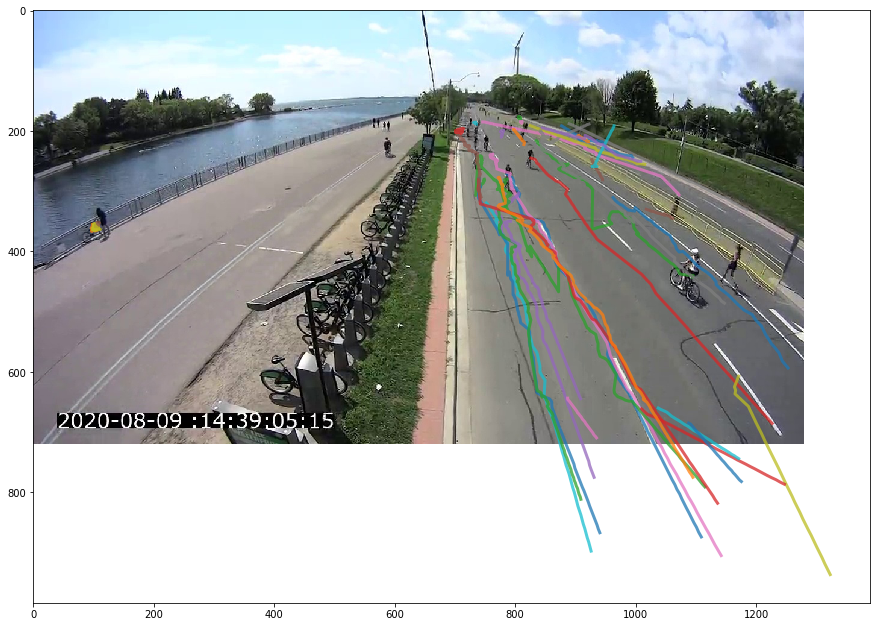

In [184]:
# Plot all trajectories to help identify where to draw gates
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(pil_img)

        
#ax.set_aspect('equal')
for _, line in trajectories.iterrows():
    x,y = line.list.xy
    ax.plot(x, y, lw=3, alpha=0.75)
plt.show()

In [224]:
# Create gates which if crossed, will increment our counters
gates = gpd.GeoSeries([
    LineString([(125,360), (430,425)]),    # (xy1, xy2)
    LineString([(700,400), (1150,400)]),   # (xy1, xy2)
    LineString([(945,250), (975,225)]),   # (xy1, xy2)
])

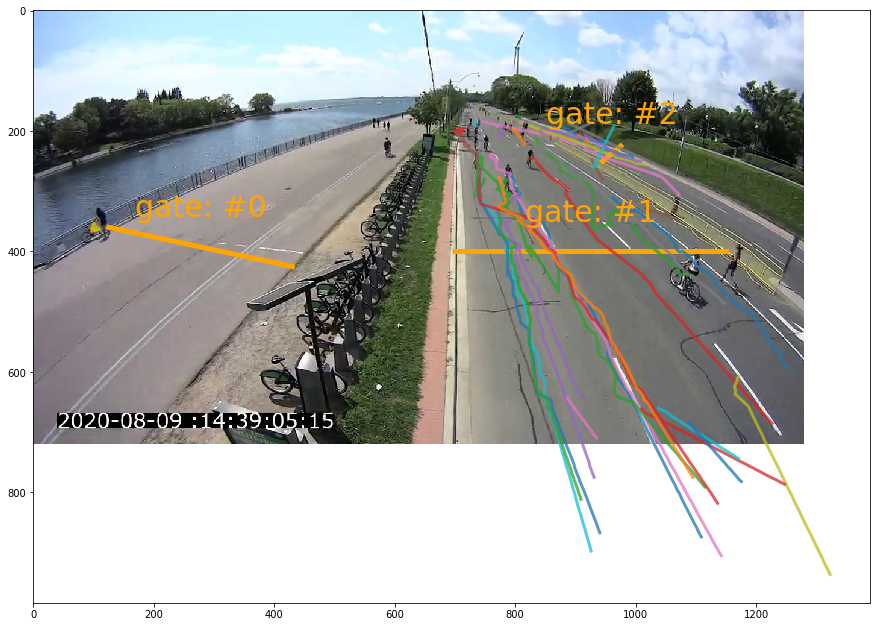

In [225]:
# let's validate that these gates are in the right place with a plot
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(pil_img)

for g, gate in enumerate(gates):
    x, y = gate.xy
    plt.plot(x, y, color='orange', linewidth=5)

    plt.text(
        sum(x)/2,
        sum(y)/2 - 50, 
        "gate: #{}".format(g), 
        color='orange', 
        horizontalalignment='center',
        fontsize=30)

for _, line in trajectories.iterrows():
    x,y = line.list.xy
    ax.plot(x, y, lw=3, alpha=0.75)

ax.set_aspect('equal')
plt.show()

In [232]:
gatecounts = defaultdict(dict)
for i, gate in gates.iteritems():
    #Crosses operates row-wise, so each gate has to be checked individually against all trajectories
    #doing the comparison in a dictionary allows for creating a dataframe through concatenation of the two columns here
    counting = {'class':trajectories.obj_class,
                'crosses': trajectories.list.crosses(gate)}
    counting = pd.concat(counting, axis=1)
    # Filter to trajectories that crossed that gate and then count
    counted = counting[counting['crosses'] == True].groupby('class').count()
    counted.reset_index(inplace=True)
    for _, class_count in counted.iterrows():
        gatecounts[i][class_count['class']] = class_count['crosses']

In [231]:
gatecounts

defaultdict(dict, {1: {'bike': 8, 'vehicle': 6}, 2: {'bike': 1, 'vehicle': 4}})